In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path
from tmm_acc import coh_tmm_normal_spol_spec_d

dtype = torch.float
device_data = torch.device('cpu')
device_test = torch.device('cuda:0')
# evaluate the model by calculating the MSE of each curve
def evaluate(model, Input, Output):
    model.eval()
    with torch.no_grad():
        Output_pred = model(Input)
        loss_mat = (Output_pred - Output) ** 2
        loss = torch.mean(loss_mat, dim=1)
        return loss.cpu().numpy(), Output_pred.cpu().numpy()

In [3]:
model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\20230712_152140')

with open(model_folder/'config.json',encoding='utf-8') as f:
    config = json.load(f)


fnet_cfg = config['fnet']
PCSED_cfg = config['PCSED']
TFNum = PCSED_cfg['TFNum']

WL = np.arange(fnet_cfg['StartWL'], fnet_cfg['EndWL'], fnet_cfg['Resolution'])

In [4]:
params = scio.loadmat(model_folder/'TrainedParams.mat')['Params']
TargetCurves = scio.loadmat(model_folder/'TargetCurves.mat')['TargetCurves']
TargetCurves_FMN = scio.loadmat(model_folder/'TargetCurves_FMN.mat')['TargetCurves_FMN']
n_array = scio.loadmat(r'D:\zf-py\graduate2\code\coatings\n_R5.0.mat')['n']


In [5]:
d_array = np.zeros((params.shape[0],params.shape[1]+2))
d_array += np.inf
d_array[:,1:-1] = params

In [6]:
T = coh_tmm_normal_spol_spec_d(n_array, d_array, WL)

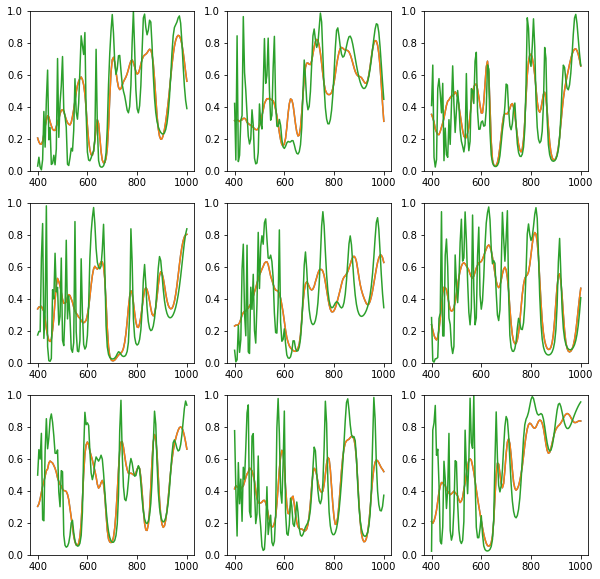

In [7]:
plt.figure(figsize=(10, 10))
for i in range(TFNum):
    plt.subplot(math.ceil(math.sqrt(TFNum)), math.ceil(math.sqrt(TFNum)), i + 1)
    plt.plot(WL, TargetCurves[i, :])
    plt.plot(WL, TargetCurves_FMN[i, :])
    plt.plot(WL, T[i, :])
    plt.ylim(0, 1)
plt.show()

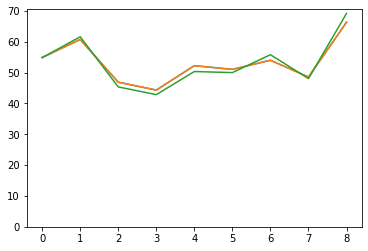

In [11]:
plt.plot(TargetCurves.sum(axis=1))
plt.plot(TargetCurves_FMN.sum(axis=1))
plt.plot(T.sum(axis=1))
plt.ylim(bottom=0)
plt.show()